# Фаза 2: Обучение и Оценка Модели Обнаружения Объектов

На этом этапе проекта мы переходим к обучению нейронной сети для обнаружения сноубордистов на подготовленном датасете. Цель — получить высокопроизводительную модель-детектор, которая будет способна точно и эффективно локализовать объекты класса 'snowboarder' на изображениях.

В первой части этой фазы мы сфокусируемся на обучении **YOLOv8** как основной архитектуры, благодаря её балансу между скоростью и точностью, что критически важно для дальнейшей интеграции в систему слежения.

---

**Примечание для читателя:**
Данный ноутбук демонстрирует процесс обучения и оценки моделей. Все конфигурационные параметры и логирование экспериментов могут быть дополнительно настроены и отслежены с помощью инструментов, таких как Weights & Biases, для более глубокого анализа.

In [ ]:
# Убедимся, что необходимые библиотеки установлены.
import os
import sys
import wandb

# Добавление корневой директории проекта в sys.path, позволяет импортировать модули из папок, расположенных на одном уровне с 'notebooks/', например из 'scripts/'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from ultralytics import YOLO
import yaml
import matplotlib.pyplot as plt
from IPython.display import Image, display

from scripts.utils import get_next_run_name 

print("Библиотеки успешно импортированы.")

Библиотеки успешно импортированы.


## 1. Обучение YOLOv8

Будем использовать фреймворк Ultralytics YOLOv8 для обучения модели.

### 1.1. Конфигурация Датасета

Перед началом обучения необходимо убедиться, что файл конфигурации `dataset.yaml` корректно указывает на подготовленные данные.

In [3]:
# Путь к файлу dataset.yaml
dataset_yaml_path = '../resources/dataset.yaml'

print(f"Содержимое файла конфигурации '{dataset_yaml_path}':")
try:
    with open(dataset_yaml_path, 'r', encoding='utf-8') as file:
        yaml_content = yaml.safe_load(file)
        print(yaml.dump(yaml_content, indent=2))
        
        # Проверим, что пути внутри dataset.yaml корректны относительно path
        base_path = yaml_content.get('path', os.path.dirname(dataset_yaml_path))
        train_path = os.path.join(base_path, yaml_content.get('train', ''))
        val_path = os.path.join(base_path, yaml_content.get('val', ''))
        test_path = os.path.join(base_path, yaml_content.get('test', ''))

        print("\nПроверка доступности путей:")
        print(f"Train images: {train_path} - {'Доступен' if os.path.exists(train_path) else 'ОШИБКА: Недоступен!'}")
        print(f"Val images: {val_path} - {'Доступен' if os.path.exists(val_path) else 'ОШИБКА: Недоступен!'}")
        print(f"Test images: {test_path} - {'Доступен' if os.path.exists(test_path) else 'ОШИБКА: Недоступен!'}")

except FileNotFoundError:
    print(f"Ошибка: Файл '{dataset_yaml_path}' не найден. Убедитесь, что он существует по указанному пути.")
except Exception as e:
    print(f"Ошибка при чтении YAML файла: {e}")

# Проверим, что train/val/test директории с аннотациями также существуют
labels_base_path = os.path.join(os.path.dirname(base_path), 'labels') # Предполагаем, что labels в одной папке с images
train_labels_path = os.path.join(labels_base_path, 'train')
val_labels_path = os.path.join(labels_base_path, 'val')
test_labels_path = os.path.join(labels_base_path, 'test')

print(f"Train labels: {train_labels_path} - {'Доступен' if os.path.exists(train_labels_path) else 'ОШИБКА: Недоступен!'}")
print(f"Val labels: {val_labels_path} - {'Доступен' if os.path.exists(val_labels_path) else 'ОШИБКА: Недоступен!'}")
print(f"Test labels: {test_labels_path} - {'Доступен' if os.path.exists(test_labels_path) else 'ОШИБКА: Недоступен!'}")

Содержимое файла конфигурации '../resources/dataset.yaml':
names:
- snowboarder
nc: 1
path: ../resources/dataset
test: images/test
train: images/train
val: images/val


Проверка доступности путей:
Train images: ../resources/dataset\images/train - Доступен
Val images: ../resources/dataset\images/val - Доступен
Test images: ../resources/dataset\images/test - Доступен
Train labels: ../resources\labels\train - ОШИБКА: Недоступен!
Val labels: ../resources\labels\val - ОШИБКА: Недоступен!
Test labels: ../resources\labels\test - ОШИБКА: Недоступен!


### 1.2. Загрузка предобученной модели и обучение

Мы начнем с загрузки предобученной модели YOLOv8 (`yolov8n.pt` — 'n' означает 'nano', самую маленькую и быструю версию). Использование предобученной модели на большом датасете (например, COCO) позволяет нам воспользоваться уже выученными признаками и значительно ускорить процесс обучения на наших специфических данных (transfer learning).

**Параметры обучения:**
* **`data`:** Путь к файлу `dataset.yaml`.
* **`epochs`:** Количество эпох обучения. Для начала, 50-100 эпох будет достаточно для демонстрации. Если модель будет недообучена, можно увеличить.
* **`imgsz`:** Размер изображения, до которого оно будет масштабироваться перед подачей в модель. 640 — стандартное значение.
* **`batch`:** Размер батча. Рекомендуется подбирать в зависимости от доступной GPU памяти. `-1` для автоматического подбора.
* **`name`:** Название эксперимента. Результаты обучения будут сохранены в `runs/detect/<name>/`.

In [ ]:
# Загрузка предобученной модели YOLOv8.
model_name_prefix = 'yolov8n' # Используем как префикс для названия папки

# Определяем имя для текущего тренировочного запуска
train_run_base_name = f"{model_name_prefix}_snowboarder"
current_train_run_name = get_next_run_name(train_run_base_name)

# Инициализация W&B run.
wandb.init(project="snowboard-tracking", name=current_train_run_name, config={
    "epochs": 100,
    "imgsz": 640,
    "batch_size": -1,
    "model_name": model_name_prefix
})

# Загрузка модели
model = YOLO(f'{model_name_prefix}.pt') 

print(f"Модель YOLOv8 ({model_name_prefix}.pt) загружена.")

# Обучение модели
print(f"\nНачинаем обучение модели YOLOv8. Результаты будут сохранены в {os.path.join('runs', 'detect', current_train_run_name)}/")
results = model.train(
    data=dataset_yaml_path,  # Путь к файлу конфигурации датасета
    epochs=100,              # Количество эпох
    imgsz=640,               # Размер изображения
    batch=-1,                # Размер батча (-1 для автоподбора)
    name=current_train_run_name, # Название эксперимента, результаты будут в runs/detect/
    # device=0,              
    # patience=50,           # Количество эпох без улучшения на val loss, после которых обучение остановится
    # resume=False           # Продолжить обучение с последней контрольной точки
)

print("\nОбучение YOLOv8 завершено.")
print(f"Результаты обучения сохранены в: {model.trainer.save_dir}")

# Сохраняем имя папки с обучением для дальнейшего использования (например, для тестирования)
latest_train_run_dir = model.trainer.save_dir

100%|██████████| 6.25M/6.25M [00:07<00:00, 885kB/s]


Модель YOLOv8 загружена.

Начинаем обучение модели YOLOv8...
Ultralytics 8.3.170  Python-3.9.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../resources/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_snowboarder_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=a

100%|██████████| 5.35M/5.35M [00:05<00:00, 1.00MB/s]


AMP: checks passed 
train: Fast image access  (ping: 6.012.8 ms, read: 36.110.2 MB/s, size: 780.5 KB)


train: Scanning D:\ML_projects\snowboard-tracking\resources\dataset\labels\train... 166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:00<00:00, 220.37it/s]

train: New cache created: D:\ML_projects\snowboard-tracking\resources\dataset\labels\train.cache
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 2060) 6.00G total, 0.10G reserved, 0.06G allocated, 5.84G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


     3011043       8.194         0.384           131          1128        (1, 3, 640, 640)                    list
     3011043       16.39         0.533         32.01         254.5        (2, 3, 640, 640)                    list
     3011043       32.78         0.837            21           140        (4, 3, 640, 640)                    list
     3011043       65.55         1.432            27           145        (8, 3, 640, 640)                    list
     3011043       131.1         2.542         63.01         165.4       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 26 for CUDA:0 4.16G/6.00G (69%) 
train: Fast image access  (ping: 0.10.0 ms, read: 78.623.1 MB/s, size: 883.5 KB)


train: Scanning D:\ML_projects\snowboard-tracking\resources\dataset\labels\train.cache... 166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:00<?, ?it/s]


val: Fast image access  (ping: 6.814.4 ms, read: 31.69.3 MB/s, size: 789.3 KB)


val: Scanning D:\ML_projects\snowboard-tracking\resources\dataset\labels\val... 41 images, 0 backgrounds, 0 corrupt: 100%|██████████| 41/41 [00:00<00:00, 214.04it/s]

val: New cache created: D:\ML_projects\snowboard-tracking\resources\dataset\labels\val.cache


Plotting labels to d:\ML_projects\snowboard-tracking\runs\detect\yolov8n_snowboarder_v1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00040625000000000004), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to d:\ML_projects\snowboard-tracking\runs\detect\yolov8n_snowboarder_v1
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.36G      1.649      4.551      1.186         13        640: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         41         41    0.00309      0.927      0.067     0.0297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.36G      1.397      3.296      1.032         18        640: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         41         41    0.00325      0.976      0.799      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.36G      1.228      2.251      0.977         16        640: 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         41         41    0.00325      0.976      0.232      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.36G       1.16      1.859     0.9782         17        640: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         41         41    0.00325      0.976      0.119     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.36G      1.139      1.616     0.9805         15        640: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         41         41    0.00244      0.732    0.00468     0.0026



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.36G      1.146      1.541     0.9634         16        640: 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         41         41    0.00154      0.463    0.00139   0.000714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.36G      1.102      1.452     0.9608         20        640: 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         41         41    0.00138      0.415    0.00103   0.000608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.36G      1.049       1.46     0.9702         12        640: 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         41         41    0.00179      0.537    0.00294     0.0017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.36G      1.043      1.327     0.9354         17        640: 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         41         41    0.00211      0.634    0.00427    0.00262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.36G      1.075      1.261     0.9612         20        640: 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         41         41     0.0022      0.659    0.00408    0.00273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.36G      1.138      1.209     0.9392         21        640: 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         41         41      0.869      0.163      0.231      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.36G      1.082      1.195     0.9365         20        640: 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         41         41          1     0.0875       0.38      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.36G      1.043      1.148     0.9525         22        640: 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         41         41      0.662      0.096      0.287      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.36G      1.166      1.146     0.9874         21        640: 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         41         41      0.705      0.195      0.376      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.36G       1.05       1.03     0.9225         22        640: 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         41         41      0.695      0.668      0.734      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.36G      1.004     0.9713     0.9063         21        640: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         41         41      0.802      0.691      0.849      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.36G     0.9737     0.9489     0.9092         20        640: 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         41         41      0.855      0.717      0.871      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.36G      1.036      1.039     0.9464         20        640: 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         41         41      0.957      0.902       0.96      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.36G     0.9835     0.9482     0.9356         16        640: 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         41         41      0.837      0.854      0.897      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.36G      0.949     0.8644     0.9272         22        640: 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         41         41      0.868      0.878      0.879      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.36G      0.929     0.8418     0.8856         25        640: 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         41         41      0.889      0.976      0.967       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.36G     0.9455     0.8302     0.9326         14        640: 100%|██████████| 7/7 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         41         41      0.916      0.976       0.97      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.36G     0.9166     0.8169     0.9261         19        640: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         41         41      0.897      0.976      0.959      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.36G     0.9846     0.7742     0.9301         20        640: 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all         41         41      0.905      0.976      0.968      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.36G     0.9815     0.7928     0.9182         15        640: 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         41         41      0.952      0.976      0.955      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.36G     0.9003      0.729     0.9148         15        640: 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         41         41      0.948      0.976      0.975       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.36G     0.8928     0.7392     0.9059         17        640: 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         41         41      0.948      0.976      0.986      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.36G     0.9123     0.6879     0.9062         25        640: 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         41         41      0.945      0.976      0.988      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.36G     0.8818     0.6858     0.8971         27        640: 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         41         41      0.929          1      0.984      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.36G     0.8648     0.6649     0.8987         14        640: 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         41         41      0.921      0.976      0.968      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.36G     0.8761     0.6691     0.9114         15        640: 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         41         41      0.889          1      0.981      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.36G     0.8629     0.6772     0.8792         23        640: 100%|██████████| 7/7 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         41         41      0.993      0.902      0.988      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.36G     0.8541     0.6544     0.8899         17        640: 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         41         41      0.873      0.927      0.955      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.36G     0.8361     0.6355     0.8753         24        640: 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         41         41      0.872      0.997      0.971      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.36G     0.8478      0.614     0.8663         18        640: 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         41         41      0.905      0.976      0.961      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.36G     0.8696     0.6158     0.8881         18        640: 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         41         41      0.947      0.951      0.956      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.36G      0.844     0.6154     0.8896         16        640: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         41         41      0.944      0.976      0.969      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.36G     0.8401     0.6078     0.8856         22        640: 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         41         41      0.975       0.97      0.978      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.36G     0.8025     0.5613     0.8795         21        640: 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         41         41      0.951      0.952      0.981      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.36G     0.8349     0.5919     0.9022         24        640: 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         41         41      0.944      0.976      0.989      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.36G      0.797     0.5726     0.8807         24        640: 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         41         41      0.944      0.976      0.981      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.36G     0.7778     0.5769     0.8642         16        640: 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         41         41      0.948          1      0.982      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.36G     0.7653     0.5492      0.872         17        640: 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         41         41      0.911      0.993      0.981        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.36G     0.8548     0.5731     0.9059         15        640: 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         41         41      0.936          1      0.981      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.36G     0.8662      0.602     0.9054         17        640: 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         41         41      0.973          1      0.988        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.36G     0.7924     0.5531     0.8705         15        640: 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         41         41      0.974          1      0.983      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.36G     0.7872     0.5701     0.8824         16        640: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         41         41      0.974          1      0.988      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.36G     0.7584     0.5569     0.8719         14        640: 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         41         41      0.974          1      0.981       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.36G     0.7088     0.5209     0.8707         19        640: 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all         41         41      0.974          1      0.989      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.36G     0.7344     0.5235     0.8655         19        640: 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         41         41      0.952      0.973      0.986      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.36G     0.6988     0.5013     0.8487         16        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         41         41      0.924      0.951      0.961      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.36G     0.7503      0.521     0.8659         23        640: 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         41         41      0.953      0.994      0.985      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.36G     0.7556     0.5301     0.8545         21        640: 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         41         41      0.931      0.981      0.973      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.36G     0.7361     0.5286      0.879         15        640: 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         41         41      0.945          1      0.977      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.36G     0.7231     0.5068     0.8531         25        640: 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         41         41      0.952      0.968       0.97      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.36G     0.7268     0.4972     0.8632         16        640: 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         41         41      0.927      0.902      0.975       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.36G     0.6812     0.4806     0.8517         15        640: 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         41         41       0.91      0.983       0.98       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.36G     0.7097      0.487     0.8637         18        640: 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         41         41      0.941          1      0.986       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.36G      0.708     0.4776     0.8572         20        640: 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         41         41      0.968          1      0.991       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.36G     0.7011     0.4859     0.8482         22        640: 100%|██████████| 7/7 [00:01<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         41         41      0.971          1      0.993      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.36G      0.664     0.4569     0.8531         15        640: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         41         41      0.973          1      0.992      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.36G     0.6603     0.4431     0.8641         21        640: 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         41         41      0.965          1      0.992      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.36G     0.6528     0.4436     0.8515         20        640: 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         41         41      0.961          1      0.993      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.36G     0.6353     0.4345     0.8391         18        640: 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         41         41      0.969          1      0.992       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.36G     0.6595      0.429     0.8288         25        640: 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         41         41      0.968          1      0.991      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.36G     0.6085     0.4389     0.8412         20        640: 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         41         41      0.941          1      0.992      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.36G     0.6217     0.4296     0.8495         20        640: 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         41         41       0.93      0.971      0.989      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.36G     0.6481     0.4514     0.8382         14        640: 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         41         41      0.931      0.992      0.989      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.36G     0.6403     0.4318     0.8497         17        640: 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         41         41      0.952          1      0.988      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.36G      0.648     0.4318     0.8468         22        640: 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         41         41      0.948          1      0.984      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.36G     0.6328     0.4354     0.8491         21        640: 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         41         41      0.946          1       0.98      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.36G     0.6556     0.4239     0.8584         18        640: 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         41         41      0.968          1      0.981      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.36G     0.6444     0.4286     0.8442         23        640: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         41         41      0.973          1      0.976      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.36G     0.6132      0.433     0.8406         15        640: 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         41         41      0.976       0.99      0.978      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.36G     0.6079     0.4312     0.8591         11        640: 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         41         41      0.971          1      0.987       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.36G     0.6286     0.4212     0.8292         23        640: 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         41         41      0.972          1       0.99      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.36G     0.6179     0.4252     0.8459         20        640: 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         41         41      0.976      0.999      0.992      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.36G     0.6032     0.4064     0.8414         21        640: 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         41         41      0.976      0.999      0.991      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.36G     0.5794        0.4     0.8423         23        640: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         41         41      0.973          1      0.992      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.36G     0.5512     0.4028     0.8222         14        640: 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         41         41      0.974          1      0.993      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.36G     0.5812     0.3965     0.8262         19        640: 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         41         41      0.972          1      0.992      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.36G     0.5834     0.4015     0.8254         23        640: 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

                   all         41         41       0.97          1      0.989      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.36G     0.5759      0.391     0.8288         20        640: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

                   all         41         41      0.972          1      0.985      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.36G     0.5387     0.3787     0.8153         18        640: 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         41         41      0.971          1      0.984      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.36G     0.5368     0.3824     0.8384         21        640: 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         41         41      0.971          1      0.987      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.36G     0.5333     0.3732     0.8227         21        640: 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         41         41       0.97          1      0.988      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.36G     0.5289     0.3743     0.8093         18        640: 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         41         41      0.971          1      0.988       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.36G     0.5367     0.3767      0.838         23        640: 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         41         41       0.97          1      0.988      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.36G     0.5438     0.3724     0.8208         16        640: 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         41         41      0.973          1      0.988       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.36G      0.525     0.3703     0.8182         14        640: 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         41         41      0.973          1      0.987       0.85


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.36G     0.4874     0.3625     0.8081         10        640: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         41         41      0.973          1      0.986      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.36G     0.4781     0.3504     0.7855         10        640: 100%|██████████| 7/7 [00:01<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         41         41      0.974          1      0.989      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.36G     0.4953     0.3631     0.8114         10        640: 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         41         41      0.974          1      0.989      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.36G     0.4579     0.3354      0.802         10        640: 100%|██████████| 7/7 [00:01<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         41         41      0.974          1      0.989      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.36G     0.4605     0.3441     0.7833         10        640: 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         41         41      0.972          1      0.988      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.36G     0.4498      0.344     0.7831         10        640: 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         41         41      0.973          1      0.988      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.36G      0.444     0.3361     0.7969         10        640: 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

                   all         41         41      0.975          1      0.986      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.36G     0.4584       0.33     0.7925         10        640: 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         41         41      0.974          1      0.986      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.36G      0.448     0.3298     0.8104         10        640: 100%|██████████| 7/7 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         41         41      0.973          1      0.986      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.36G     0.4302     0.3251      0.799         10        640: 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         41         41      0.972          1      0.986      0.852



100 epochs completed in 0.063 hours.
Optimizer stripped from d:\ML_projects\snowboard-tracking\runs\detect\yolov8n_snowboarder_v1\weights\last.pt, 6.2MB
Optimizer stripped from d:\ML_projects\snowboard-tracking\runs\detect\yolov8n_snowboarder_v1\weights\best.pt, 6.2MB

Validating d:\ML_projects\snowboard-tracking\runs\detect\yolov8n_snowboarder_v1\weights\best.pt...
Ultralytics 8.3.170  Python-3.9.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


                   all         41         41      0.969          1      0.992      0.868
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to d:\ML_projects\snowboard-tracking\runs\detect\yolov8n_snowboarder_v1

Обучение YOLOv8 завершено.
Результаты обучения сохранены в: d:\ML_projects\snowboard-tracking\runs\detect\yolov8n_snowboarder_v1


### 1.3. Анализ Результатов Обучения YOLOv8

Обучение модели YOLOv8n завершилось успешно, показав отличные метрики на валидационном наборе.

**Ключевые показатели после 100 эпох:**

* **Итоговая оценка на валидационном наборе (по модели `best.pt`):**
    * `Precision (P)`: **0.969** - Из всех предсказаний, почти 97% были корректными.
    * `Recall (R)`: **1** - Модель обнаружила абсолютно всех (или почти всех) сноубордистов на валидационных изображениях.
    * `mAP50`: **0.992** - Практически идеальная средняя точность при пороге IoU 0.5.
    * `mAP50-95`: **0.868** - Очень высокий показатель средней точности по диапазону порогов IoU, свидетельствующий о превосходном качестве предсказанных ограничивающих рамок.

* **Скорость инференса на GPU (NVIDIA GeForce RTX 2060):**
    * ~1.3 миллисекунды на изображение, что составляет примерно **~769 кадров в секунду (FPS)**. Это делает модель крайне подходящей для задач реального времени.

Такие результаты свидетельствуют о высоком качестве подготовленного датасета и эффективности выбранной архитектуры YOLOv8 для данной задачи. Модель успешно выучила признаки сноубордистов и демонстрирует отличную способность к их обнаружению.

## 2. Тестирование Модели на Независимой Тестовой Выборке

После успешного обучения и оценки на валидационном наборе, критически важно проверить производительность модели на **невиданной ранее независимой тестовой выборке**. Это дает наиболее объективную оценку обобщающей способности модели.

Мы используем веса `best.pt`, полученные в результате обучения, для проведения валидации на тестовом наборе.

Загружаем лучшую модель из: d:\ML_projects\snowboard-tracking\runs\detect\yolov8n_snowboarder_v1\weights\best.pt

Запускаем валидацию на тестовом наборе...
Ultralytics 8.3.170  Python-3.9.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 3868.5616.9 MB/s, size: 839.6 KB)


val: Scanning D:\ML_projects\snowboard-tracking\resources\dataset\labels\test.cache... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


                   all         63         63      0.984          1      0.995      0.842
Speed: 1.8ms preprocess, 7.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to d:\ML_projects\snowboard-tracking\runs\detect\val6

Валидация на тестовом наборе завершена.

Метрики на тестовом наборе:
  Precision (P): 0.984
  Recall (R): 1.000
  mAP50: 0.995
  mAP50-95: 0.842

Примеры предсказаний и графики оценки на тестовом наборе сохранены в: d:\ML_projects\snowboard-tracking\runs\detect\val6

Визуализация тестовых предсказаний (первый батч):


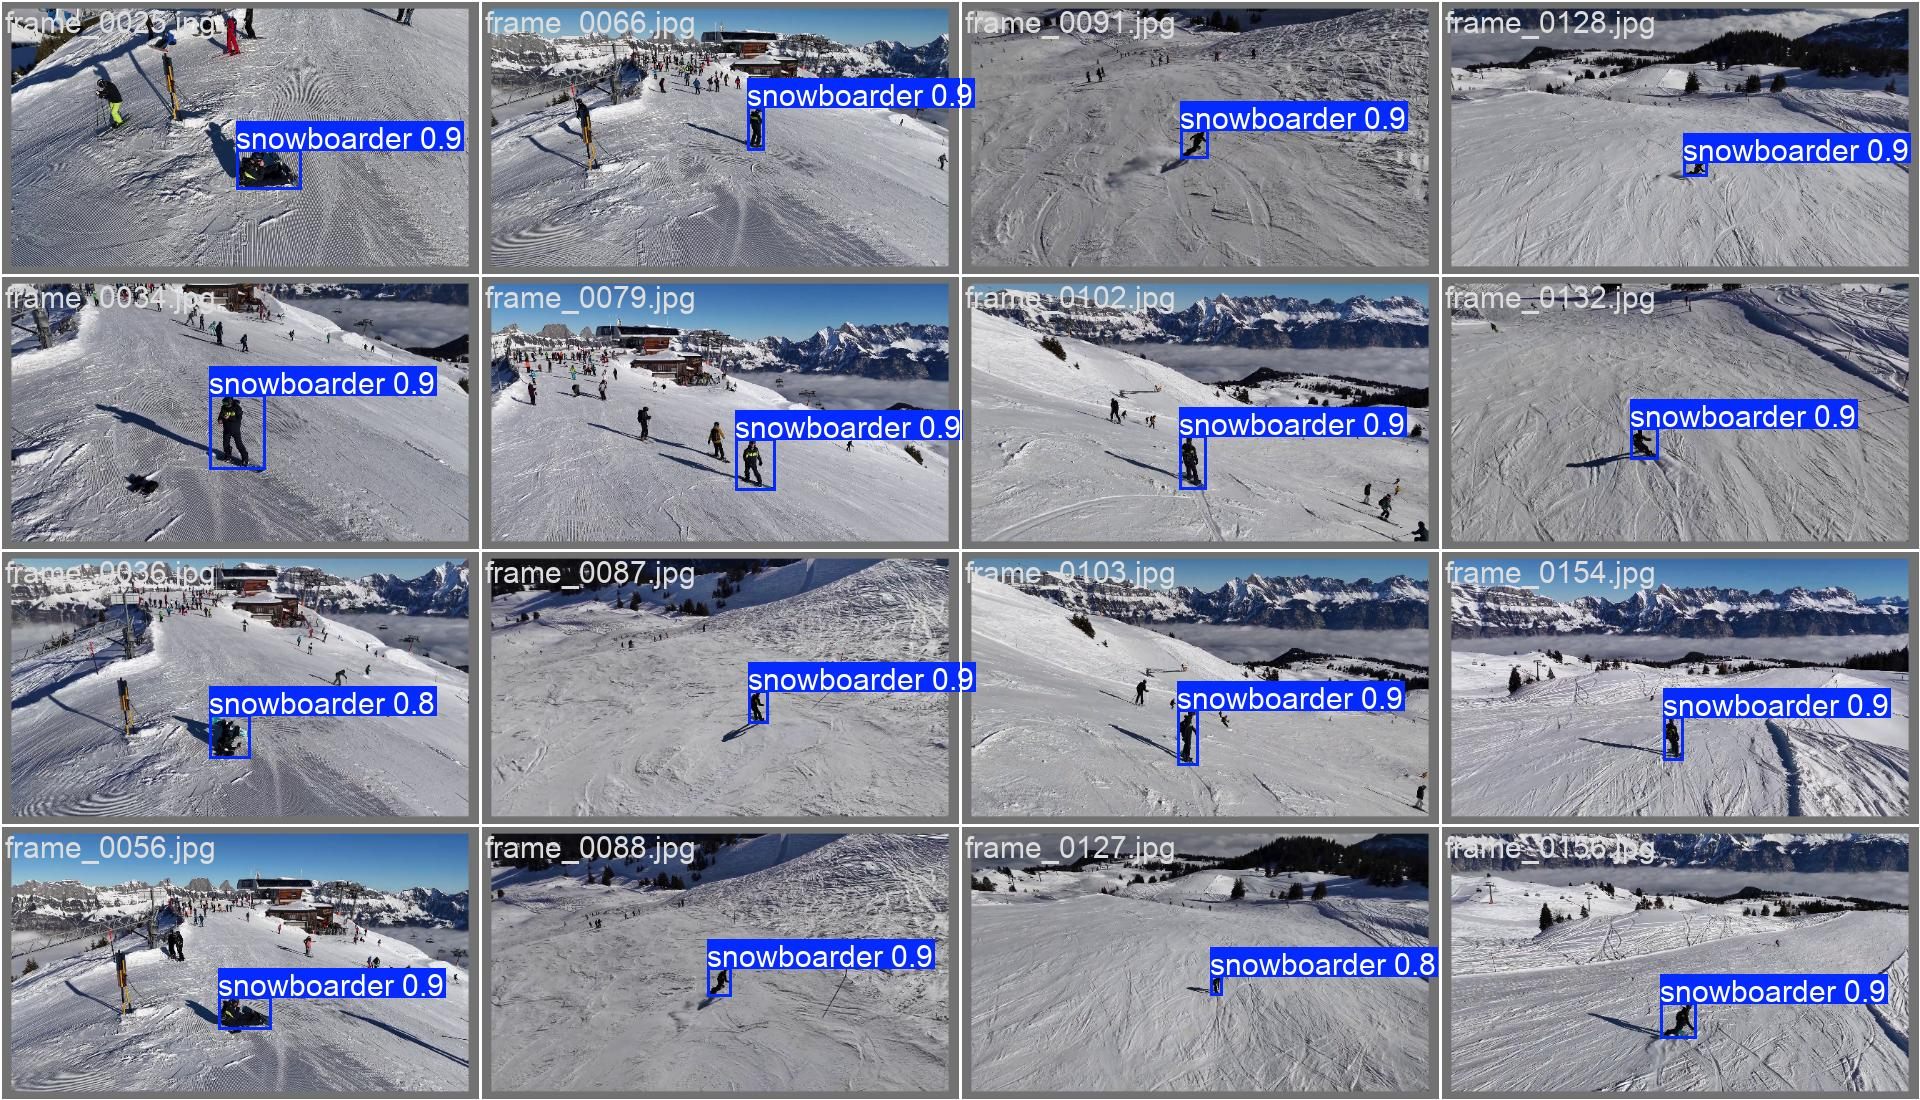


PR-кривая на тестовом наборе:
Файл 'PR_curve.png' не найден в d:\ML_projects\snowboard-tracking\runs\detect\val6.


In [ ]:
# Загрузка лучшей обученной модели
# Используем путь к последнему тренировочному запуску, чтобы найти best.pt
best_model_path = os.path.join(latest_train_run_dir, 'weights', 'best.pt')

print(f"Загружаем лучшую модель из: {best_model_path}")
loaded_model = YOLO(best_model_path)

# Определяем имя для текущего тестового запуска
# Берем префикс из train_run_base_name
test_run_base_name = f"test_{model_name_prefix}_snowboarder"
current_test_run_name = get_next_run_name(test_run_base_name)

# Проведение валидации на тестовом наборе
print("\nЗапускаем валидацию на тестовом наборе...")
test_results = loaded_model.val(
    data=dataset_yaml_path,      # Используем тот же dataset.yaml
    split='test',                # Указываем, что валидацию нужно провести на тестовом наборе
    imgsz=640,
    conf=0.25,                   # Порог уверенности для детекции (можно настроить)
    iou=0.7,                     # Порог IoU для NMS (можно настроить)
    plots=True,                  # Генерировать графики результатов
    name=current_test_run_name   # Динамическое имя для тестового запуска
)

print("\nВалидация на тестовом наборе завершена.")

# Вывод основных метрик на тестовом наборе
print("\nМетрики на тестовом наборе:")
final_p = test_results.box.p.item()
final_r = test_results.box.r.item()
final_map50 = test_results.box.map50.item()
final_map = test_results.box.map.item()

print(f"  Precision (P): {final_p:.3f}")
print(f"  Recall (R): {final_r:.3f}")
print(f"  mAP50: {final_map50:.3f}")
print(f"  mAP50-95: {final_map:.3f}")

# Логирование финальных метрик тестового набора в W&B
wandb.log({
    "test/precision": final_p,
    "test/recall": final_r,
    "test/mAP50": final_map50,
    "test/mAP50-95": final_map
})

# Путь к сгенерированным графикам (например, labels.jpg, confusion_matrix.png, P_curve.png, R_curve.png)
plots_test_dir = test_results.save_dir

print(f"\nПримеры предсказаний и графики оценки на тестовом наборе сохранены в: {plots_test_dir}")

# Логирование графиков как артефактов в W&B
wandb_artifacts = {}

try:
    pred_image_path = os.path.join(plots_test_dir, 'val_batch0_pred.jpg')
    if os.path.exists(pred_image_path):
        print("\nВизуализация тестовых предсказаний (первый батч):")
        display(Image(filename=pred_image_path))
        wandb_artifacts["test/val_batch0_pred"] = wandb.Image(pred_image_path, caption="Test Batch 0 Predictions")
    else:
        print(f"Файл 'val_batch0_pred.jpg' не найден в {plots_test_dir}. Убедитесь, что 'plots=True' и путь верен.")
except Exception as e:
    print(f"Не удалось отобразить изображение или залогировать в W&B: {e}")

try:
    pr_curve_path = os.path.join(plots_test_dir, 'BoxPR_curve.png')
    if os.path.exists(pr_curve_path):
        print("\nPR-кривая на тестовом наборе:")
        display(Image(filename=pr_curve_path))
        wandb_artifacts["test/PR_curve"] = wandb.Image(pr_curve_path, caption="BoxPR Curve on Test Set")
    else:
        print(f"Файл 'BoxPR_curve.png' не найден в {plots_test_dir}.")
except Exception as e:
    print(f"Не удалось отобразить PR-кривую или залогировать в W&B: {e}")

# Залогировать все собранные артефакты
if wandb_artifacts:
    wandb.log(wandb_artifacts)

# Завершаем W&B run
wandb.finish()

### 2.1. Анализ Результатов на Тестовой Выборке

Результаты валидации на независимой тестовой выборке подтверждают высокую обобщающую способность обученной модели YOLOv8n.

**Ключевые показатели на тестовом наборе (63 изображения):**

* `Precision (P)`: **0.984** - Модель демонстрирует крайне низкое количество ложных срабатываний.
* `Recall (R)`: **1.000** - Модель успешно обнаружила всех сноубордистов, присутствующих в тестовом наборе. Это критически важно для задачи трекинга, так как пропущенные детекции значительно ухудшают качество трекинга.
* `mAP50`: **0.995** - Практически идеальная средняя точность при пороге IoU 0.5, что говорит о высочайшем качестве локализации объектов.
* `mAP50-95`: **0.842** - Очень сильный показатель, указывающий на хорошую точность рамок даже при строгих порогах IoU.

Скорость инференса модели также остается на высоком уровне (~1.8 мс на изображение), что обеспечивает возможность работы в реальном времени.

Эти метрики являются **отличным фундаментом** для построения надежной системы слежения за сноубордистом. Модель-детектор готова к интеграции с алгоритмами трекинга.

## 3. Визуализация Процесса Обучения

Ultralytics автоматически генерирует полезные графики во время обучения, которые позволяют отслеживать прогресс модели и выявлять потенциальные проблемы (например, переобучение или недообучение). Эти графики находятся в папке, где были сохранены результаты обучения (`yolov8n_snowboarder_v1`).

Мы отобразим ключевые графики:
* `results.png`: Сводный график потерь и метрик (mAP, Precision, Recall) по эпохам.
* `PR_curve.png`: Precision-Recall кривая.
* `confusion_matrix.png`: Матрица ошибок.

Путь к результатам обучения: ..\runs\detect\yolov8n_snowboarder_v1

Сводный график результатов обучения (потери и метрики по эпохам):


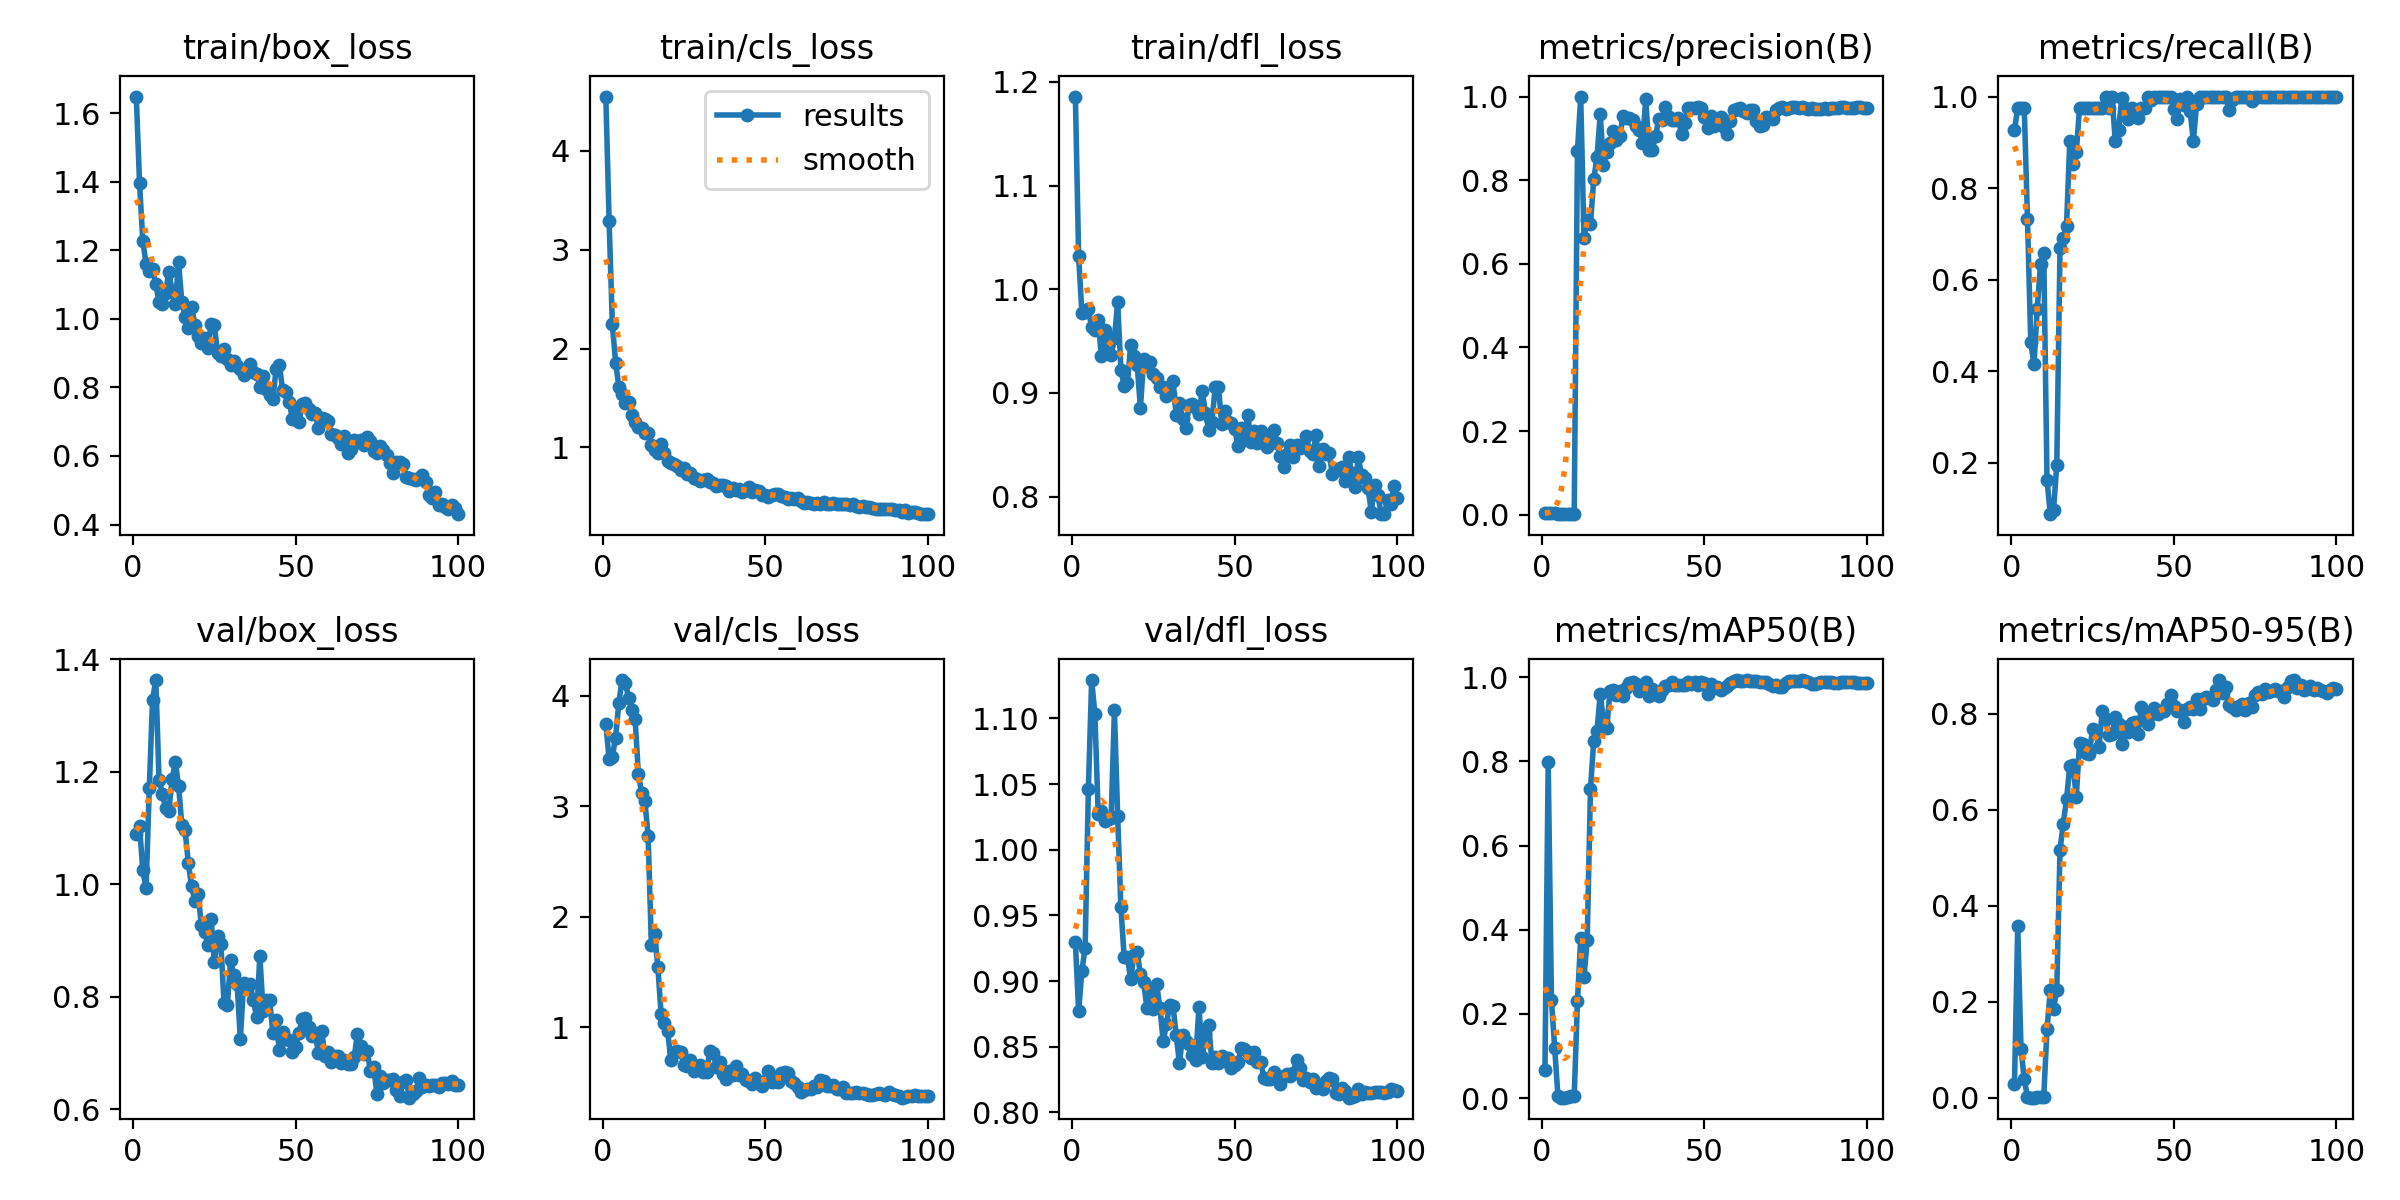


Precision-Recall кривая:


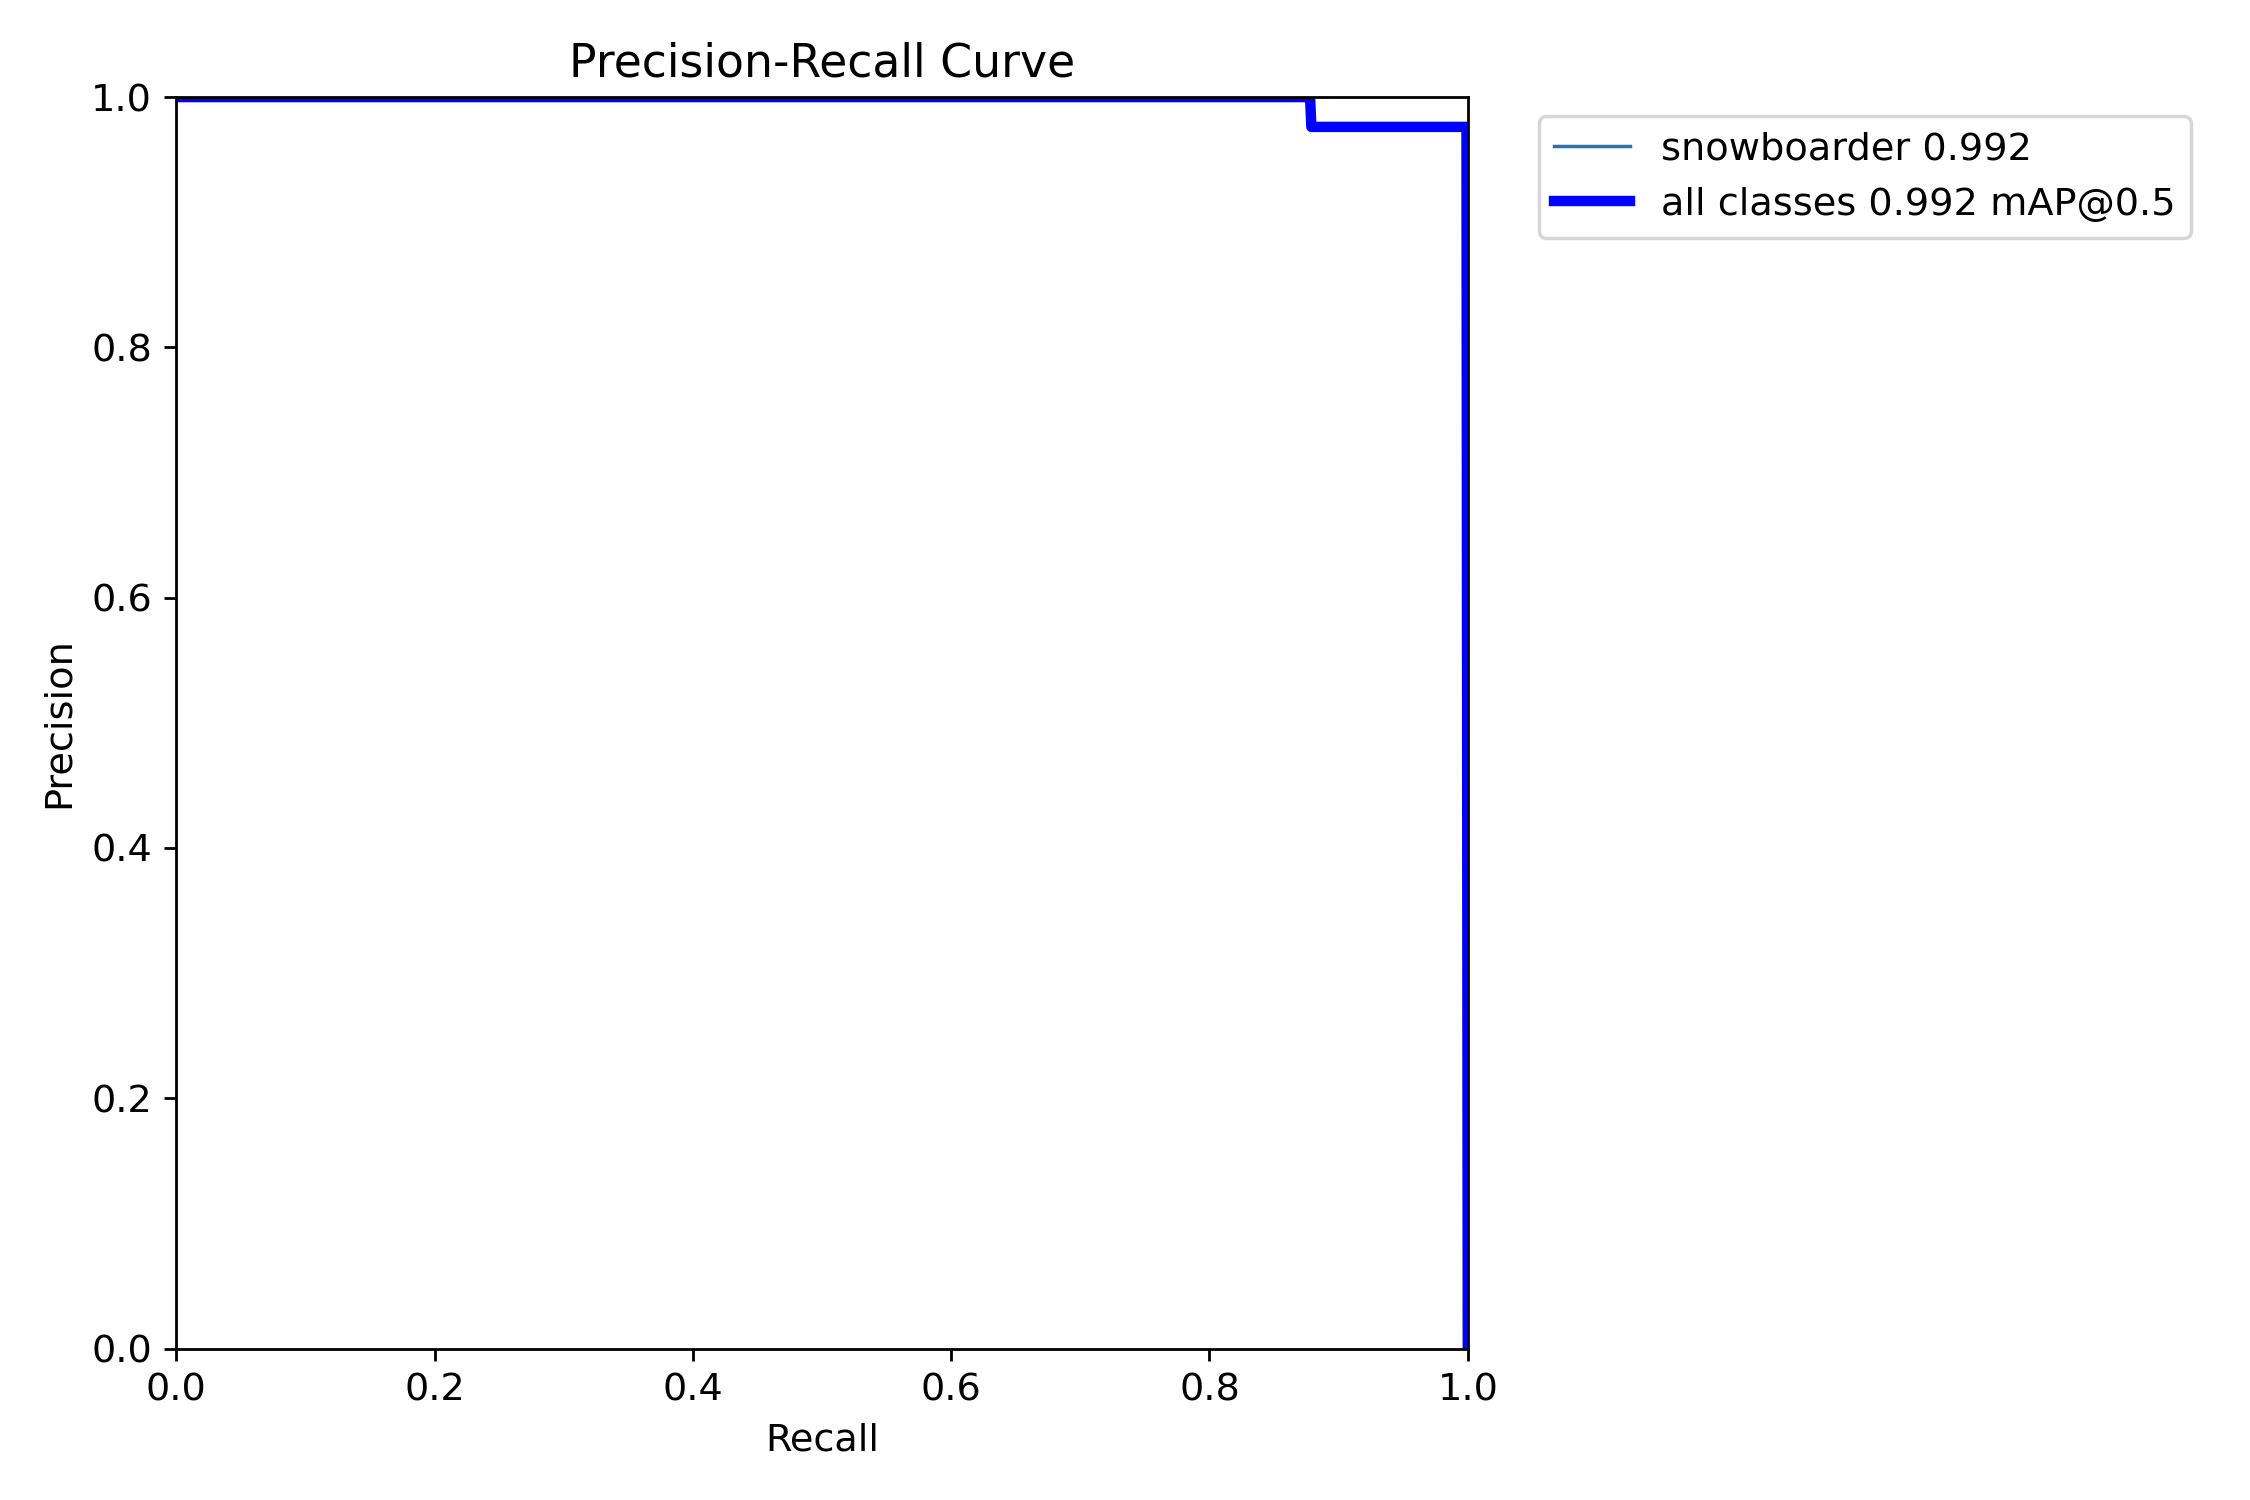


Матрица ошибок (Confusion Matrix):


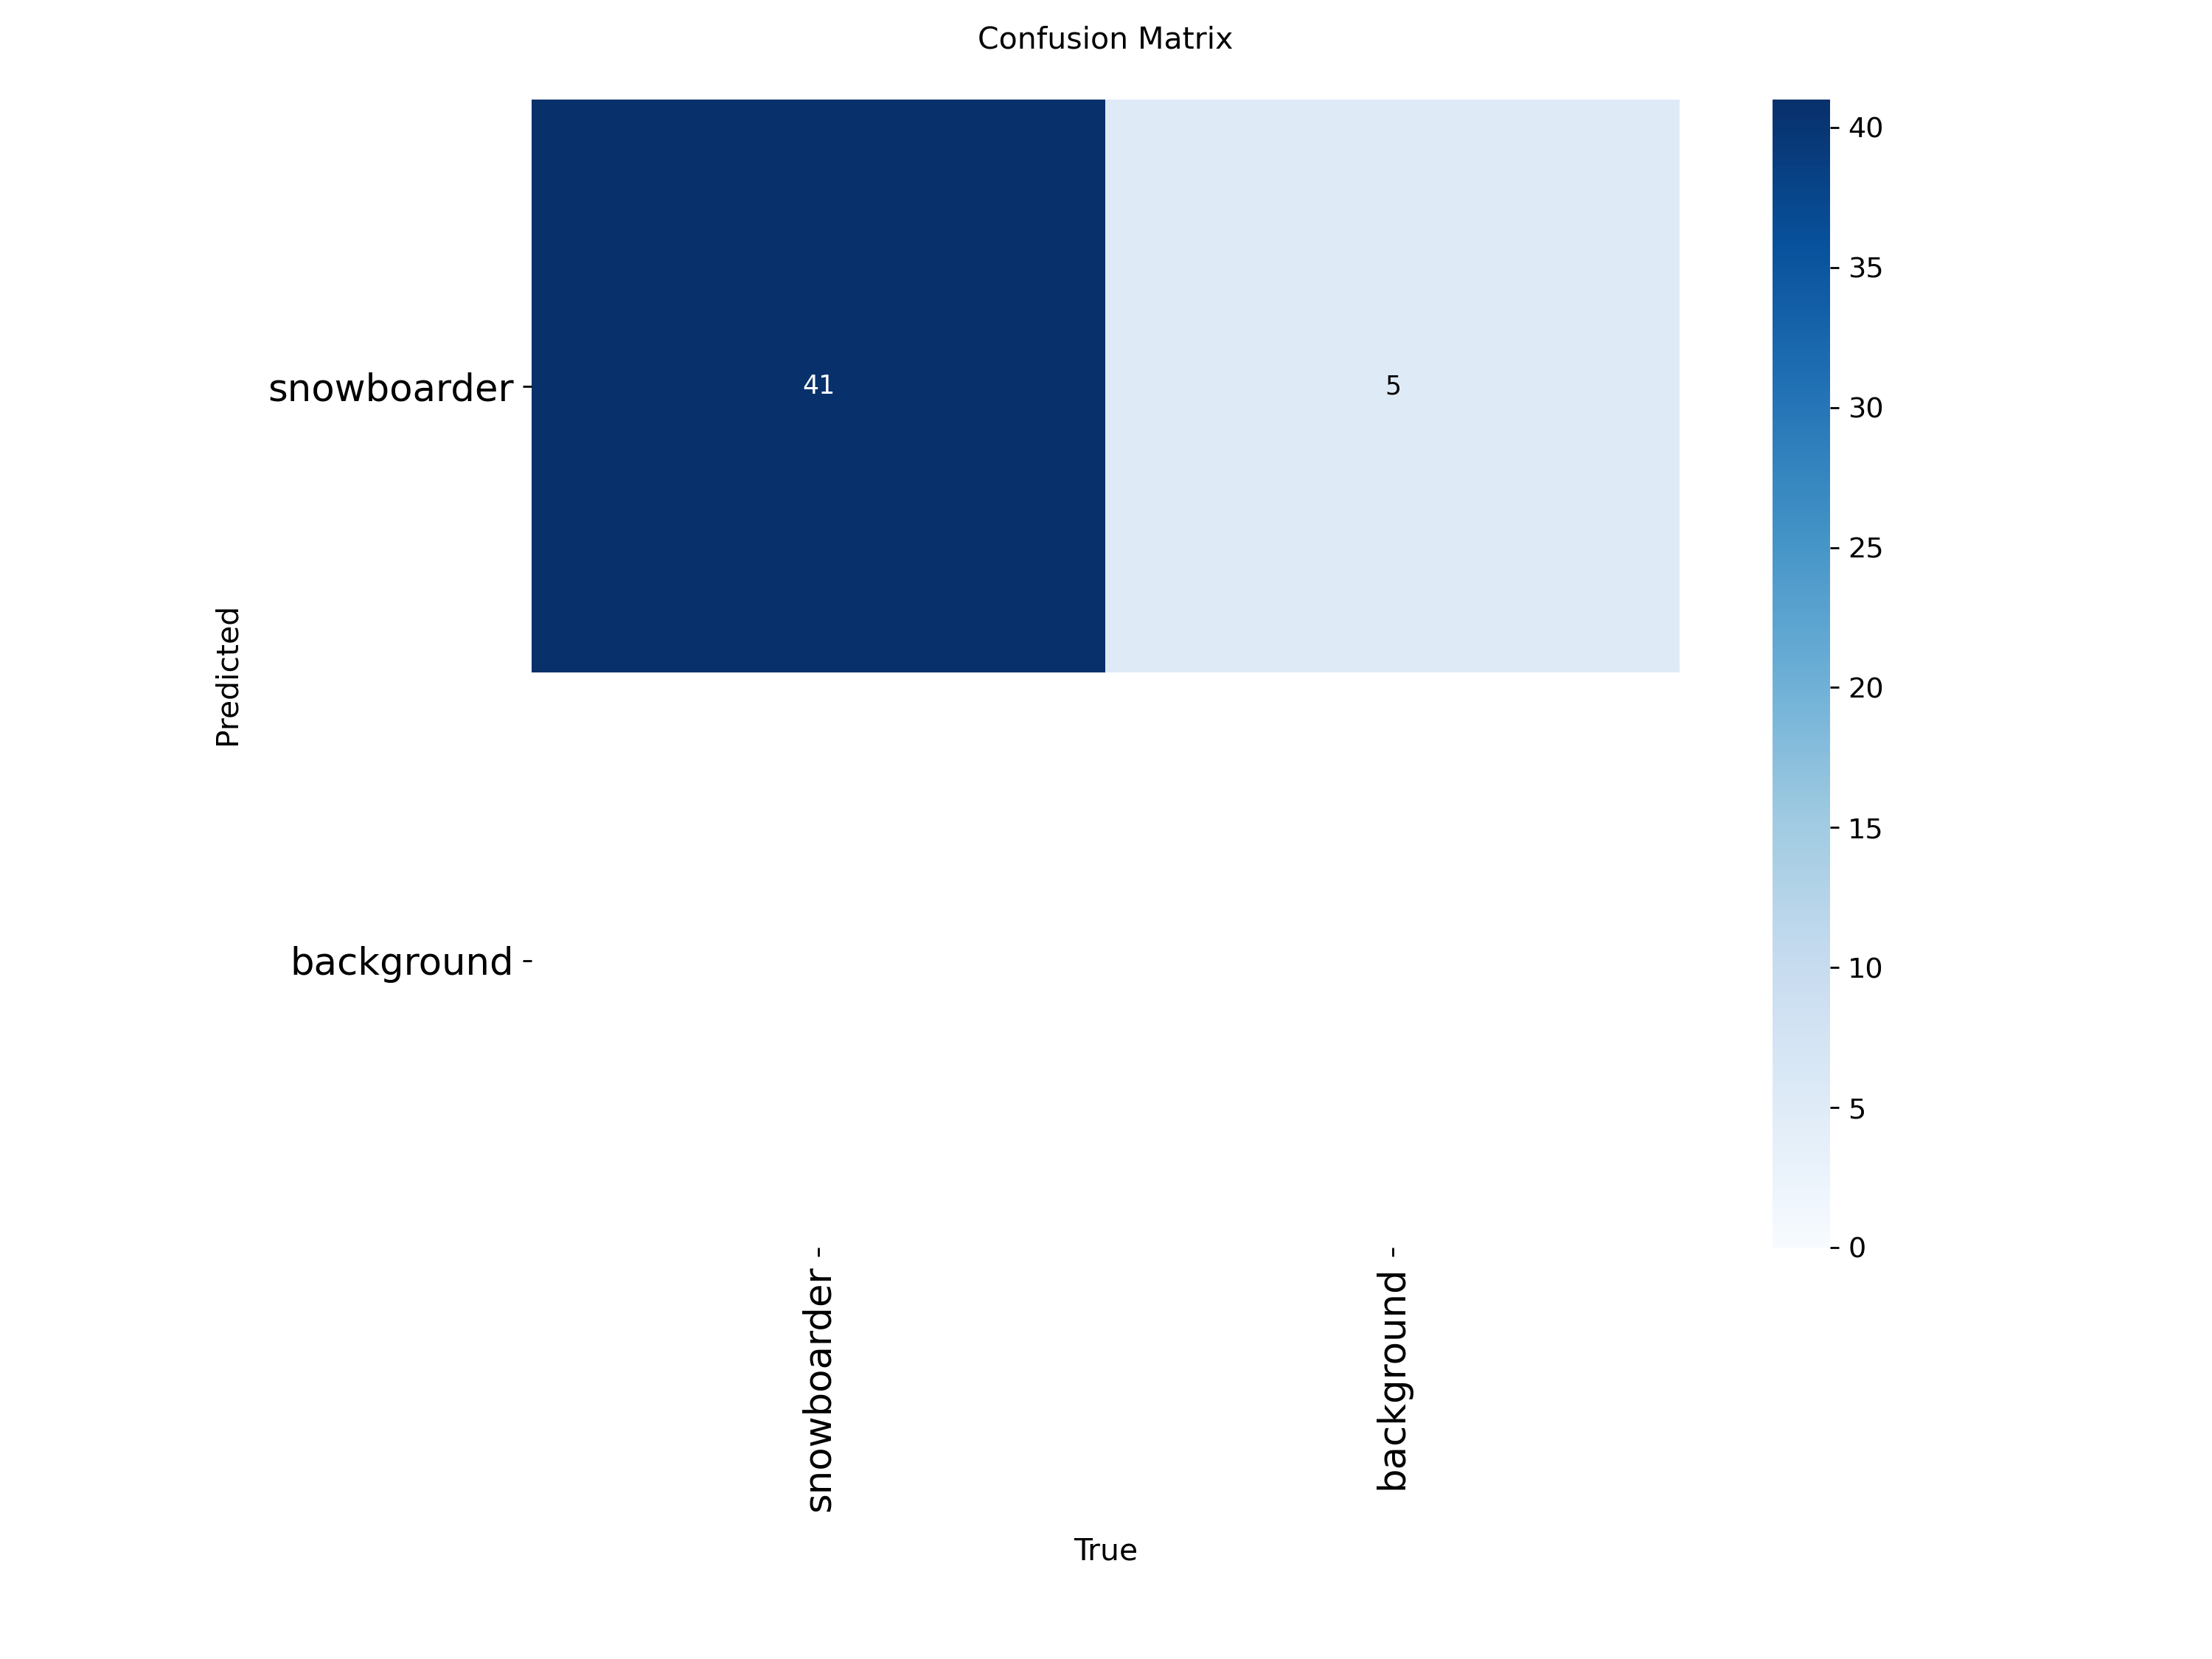

In [16]:
# Путь к папке с результатами обучения
train_results_dir = os.path.join('..', 'runs', 'detect', 'yolov8n_snowboarder_v1') 

print(f"Путь к результатам обучения: {train_results_dir}")

# Отображение сводного графика результатов
try:
    print("\nСводный график результатов обучения (потери и метрики по эпохам):")
    display(Image(filename=os.path.join(train_results_dir, 'results.png')))
except FileNotFoundError:
    print(f"Файл 'results.png' не найден по пути: {os.path.join(train_results_dir, 'results.png')}.")
except Exception as e:
    print(f"Не удалось отобразить 'results.png': {e}")

# Отображение PR-кривой
try:
    print("\nPrecision-Recall кривая:")
    display(Image(filename=os.path.join(train_results_dir, 'BoxPR_curve.png'), width=600)) 
except FileNotFoundError:
    print(f"Файл 'BoxPR_curve.png' не найден по пути: {os.path.join(train_results_dir, 'BoxPR_curve.png')}.")
except Exception as e:
    print(f"Не удалось отобразить 'BoxPR_curve.png': {e}")

# Отображение матрицы ошибок
try:
    print("\nМатрица ошибок (Confusion Matrix):")
    display(Image(filename=os.path.join(train_results_dir, 'confusion_matrix.png'), width=600)) 
except FileNotFoundError:
    print(f"Файл 'confusion_matrix.png' не найден по пути: {os.path.join(train_results_dir, 'confusion_matrix.png')}.")
except Exception as e:
    print(f"Не удалось отобразить 'confusion_matrix.png': {e}")